# Recommender System for Skin Care Products

![](../images/Skin_products.jpg)

#### Importing necessary modules and utility functions

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import pandas as pd
import numpy as np

from stop_words import get_stop_words
en_stop = get_stop_words('en')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

import copy
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use("ggplot")

import warnings
warnings.filterwarnings("ignore")

# [1]. Reading Data

In [2]:
skincare_df = pd.read_csv("../data/review database - sephora (17085).csv")

In [3]:
# Copying the raw data
df = copy.deepcopy(skincare_df)

In [4]:
df.head()

,Product Name,Brand,ISBN,Product ID,Product Page URL,Reviewer Username,Rating,Recommends,Profile Pic,Review Comment,Age,Eye Color,Hair Color,Skin Tone,Skin Type
0,100% Organic Virgin Chia Seed Oil,The Ordinary,[],P447597,https://www.sephora.com/product/100-organic-vi...,mua4life,2,False,https://sephora.i.lithium.com/t5/image/serverp...,I have dry skin so maybe that’s why but I foun...,NaN,Brown,Black,Dark,Dry
1,100% Organic Virgin Chia Seed Oil,The Ordinary,[],P447597,https://www.sephora.com/product/100-organic-vi...,rachel18534,5,True,https://sephora.i.lithium.com/t5/image/serverp...,Lightweight and hydrating! I love this oil at ...,NaN,Brown,Black,Dark,Oily
2,100% Organic Virgin Chia Seed Oil,The Ordinary,[],P447597,https://www.sephora.com/product/100-organic-vi...,KarlieFries,5,True,https://sephora.i.lithium.com/t5/image/serverp...,"This is a thin oil, so unless you’re extremely...",NaN,Brown,Auburn,Light,Combination
3,100% Organic Virgin Chia Seed Oil,The Ordinary,[],P447597,https://www.sephora.com/product/100-organic-vi...,malayabilinski,3,False,https://sephora.i.lithium.com/t5/image/serverp...,made me personally break out a little bit so i...,NaN,NaN,NaN,NaN,Combination
4,100% Organic Virgin Chia Seed Oil,The Ordinary,[],P447597,https://www.sephora.com/product/100-organic-vi...,Hugsy1,5,True,https://sephora.i.lithium.com/t5/image/serverp...,It is absolutely amazing. but your face will s...,35-44,Brown,Brunette,Medium,Normal


In [5]:
df.columns

Index(['Product Name', 'Brand', 'ISBN', 'Product ID', 'Product Page URL',
       'Reviewer Username', 'Rating', 'Recommends', 'Profile Pic',
       'Review Comment', 'Age', 'Eye Color', 'Hair Color', 'Skin Tone',
       'Skin Type'],
      dtype='object')

#  Exploratory Data Analysis

## [2] Data Cleaning: 
Removing the data where the reviews are not given because we're predicting the skin type just based on the reviews text.

In [6]:
# Subsetting the columns which are necessary for the analysis
colsTodrop = ['ISBN', 'Product Page URL', 'Recommends', 'Profile Pic', 'Age', 'Eye Color', 'Hair Color', 'Skin Tone']
df = df.drop(colsTodrop, axis=1)

# Dropping the rows where the review comment is not given
df.dropna(subset=['Review Comment'], inplace = True)

# Renaming columns for simplicity
df.columns = df.columns.str.strip().str.replace(' ', '_')

In [7]:
df.head()

,Product_Name,Brand,Product_ID,Reviewer_Username,Rating,Review_Comment,Skin_Type
0,100% Organic Virgin Chia Seed Oil,The Ordinary,P447597,mua4life,2,I have dry skin so maybe that’s why but I foun...,Dry
1,100% Organic Virgin Chia Seed Oil,The Ordinary,P447597,rachel18534,5,Lightweight and hydrating! I love this oil at ...,Oily
2,100% Organic Virgin Chia Seed Oil,The Ordinary,P447597,KarlieFries,5,"This is a thin oil, so unless you’re extremely...",Combination
3,100% Organic Virgin Chia Seed Oil,The Ordinary,P447597,malayabilinski,3,made me personally break out a little bit so i...,Combination
4,100% Organic Virgin Chia Seed Oil,The Ordinary,P447597,Hugsy1,5,It is absolutely amazing. but your face will s...,Normal


In [8]:
# Lets check the number of unique users for the Brand **Sephora**
print("The number of unique users: {}".format(df["Reviewer_Username"].nunique()))

print("The number of unique products: {}".format(df["Product_ID"].nunique()))

The number of unique users: 14988
The number of unique products: 119


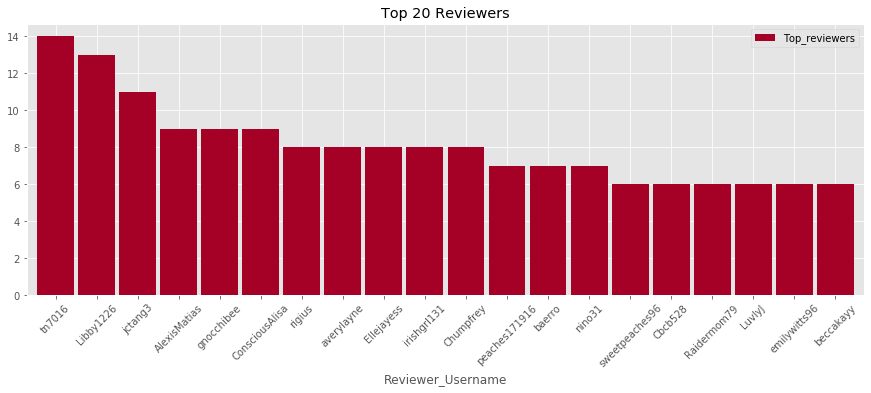

In [9]:
# Plotting the top 20 users who gave most reviews
most_reviewers = copy.deepcopy(df)
most_reviewers['Top_reviewers'] = 1
most_reviewers = most_reviewers.groupby(['Reviewer_Username']).agg({'Top_reviewers': 'count'}).reset_index()
top_reviews = most_reviewers.sort_values(by='Top_reviewers',ascending=False)[:20]

top_reviews.set_index('Reviewer_Username',inplace=True)
top_reviews.plot.bar(width=0.9,cmap='RdYlGn')
fig=plt.gcf()
fig.set_size_inches(15,5)
plt.title('Top 20 Reviewers')
plt.xticks(rotation = 45)
plt.show()

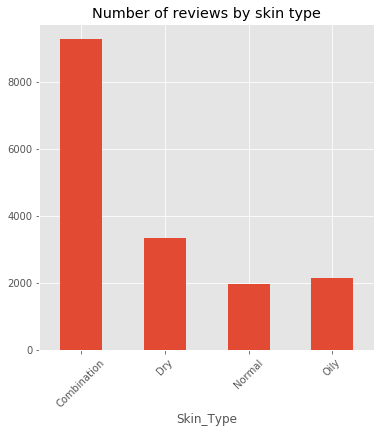

In [10]:
fig = plt.figure(figsize=(6,6))
df.groupby('Skin_Type').Review_Comment.count().plot.bar(ylim=0)
plt.title('Number of reviews by skin type')
plt.xticks(rotation = 45)
plt.show()

# [3].  Text Preprocessing.

Our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Remove any punctuations or limited set of special characters like , or . or # etc.
2. Check if the word is made up of english letters and is not alpha-numeric
3. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
4. Convert the word to lowercase
5. Remove Stopwords


After performing the above steps will we get the cleaned corpus review texts.

In [11]:
# printing some random reviews
sent_1000 = df['Review_Comment'].values[1000]
print(sent_1000)

When I ordered this in May, I was really surprised that the smallest drop of it goes a LONG way.  I was so impressed I ordered a second bottle in August and haven't looked back since.   
Skinfix's Barrier  Foaming Cleanser is gentle enough I can use it on a nightly basis with lukewarm or cold water to rinse it off.  
After trying other Brands' Cleansers, I FINALLY found THE Cleanser for Me.
For $42.92 with taxes for a 177 ml bottle, it is well worth the money.  If you use a  small drop, it should last you for months.


In [12]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # general
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [13]:
sent_1000 = decontracted(sent_1000)
print(sent_1000)
print("="*50)

When I ordered this in May, I was really surprised that the smallest drop of it goes a LONG way.  I was so impressed I ordered a second bottle in August and have not looked back since.   
Skinfix is Barrier  Foaming Cleanser is gentle enough I can use it on a nightly basis with lukewarm or cold water to rinse it off.  
After trying other Brands' Cleansers, I FINALLY found THE Cleanser for Me.
For $42.92 with taxes for a 177 ml bottle, it is well worth the money.  If you use a  small drop, it should last you for months.


In [14]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_1000 = re.sub("\S*\d\S*", "", sent_1000).strip()
print(sent_1000)

When I ordered this in May, I was really surprised that the smallest drop of it goes a LONG way.  I was so impressed I ordered a second bottle in August and have not looked back since.   
Skinfix is Barrier  Foaming Cleanser is gentle enough I can use it on a nightly basis with lukewarm or cold water to rinse it off.  
After trying other Brands' Cleansers, I FINALLY found THE Cleanser for Me.
For  with taxes for a  ml bottle, it is well worth the money.  If you use a  small drop, it should last you for months.


In [15]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1000 = re.sub('[^A-Za-z0-9]+', ' ', sent_1000)
print(sent_1000)

When I ordered this in May I was really surprised that the smallest drop of it goes a LONG way I was so impressed I ordered a second bottle in August and have not looked back since Skinfix is Barrier Foaming Cleanser is gentle enough I can use it on a nightly basis with lukewarm or cold water to rinse it off After trying other Brands Cleansers I FINALLY found THE Cleanser for Me For with taxes for a ml bottle it is well worth the money If you use a small drop it should last you for months 


In [16]:
# Combining all the above preprocessing steps
def preprocessing(review):
    review = decontracted(review)
    review = re.sub("\S*\d\S*", "", review).strip()  # remove numbers
    review = re.sub('[^A-Za-z]+', ' ', review)       # remove special characters
    # https://gist.github.com/sebleier/554280
    review = ' '.join(e.lower() for e in review.split() if e.lower() not in en_stop and len(e) > 2)
    return review.strip()

In [17]:
print(sent_1000,"\n")
print("After preprocessing...")
print(preprocessing(sent_1000))

When I ordered this in May I was really surprised that the smallest drop of it goes a LONG way I was so impressed I ordered a second bottle in August and have not looked back since Skinfix is Barrier Foaming Cleanser is gentle enough I can use it on a nightly basis with lukewarm or cold water to rinse it off After trying other Brands Cleansers I FINALLY found THE Cleanser for Me For with taxes for a ml bottle it is well worth the money If you use a small drop it should last you for months  

After preprocessing...
ordered may really surprised smallest drop goes long way impressed ordered second bottle august looked back since skinfix barrier foaming cleanser gentle enough can use nightly basis lukewarm cold water rinse trying brands cleansers finally found cleanser taxes bottle well worth money use small drop last months


In [18]:
# Finally adding the preprocessed reviews in the dataframe
df["cleaned_reviews"] = df["Review_Comment"].apply(preprocessing)

In [19]:
df.head()

,Product_Name,Brand,Product_ID,Reviewer_Username,Rating,Review_Comment,Skin_Type,cleaned_reviews
0,100% Organic Virgin Chia Seed Oil,The Ordinary,P447597,mua4life,2,I have dry skin so maybe that’s why but I foun...,Dry,dry skin maybe found nothing skin personally s...
1,100% Organic Virgin Chia Seed Oil,The Ordinary,P447597,rachel18534,5,Lightweight and hydrating! I love this oil at ...,Oily,lightweight hydrating love oil end night skin ...
2,100% Organic Virgin Chia Seed Oil,The Ordinary,P447597,KarlieFries,5,"This is a thin oil, so unless you’re extremely...",Combination,thin oil unless extremely prone breakouts due ...
3,100% Organic Virgin Chia Seed Oil,The Ordinary,P447597,malayabilinski,3,made me personally break out a little bit so i...,Combination,made personally break little bit stopped using...
4,100% Organic Virgin Chia Seed Oil,The Ordinary,P447597,Hugsy1,5,It is absolutely amazing. but your face will s...,Normal,absolutely amazing face will stink fish might ...


# Base skin type match

In [20]:
st_df = df[["cleaned_reviews", "Skin_Type"]]
st_df.dropna(inplace = True)
#st_df['Skin_Type'] = st_df.iloc[:, 1].astype(str).replace({'Dry':0,'Oily':1, 'Combination':2, 'Normal':3})
st_df.head()

,cleaned_reviews,Skin_Type
0,dry skin maybe found nothing skin personally s...,Dry
1,lightweight hydrating love oil end night skin ...,Oily
2,thin oil unless extremely prone breakouts due ...,Combination
3,made personally break little bit stopped using...,Combination
4,absolutely amazing face will stink fish might ...,Normal


In [21]:
X = st_df['cleaned_reviews'].values
Y = st_df['Skin_Type'].values

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33) # this is random splitting

In [23]:
def classify(X_train, y_train, X_test, y_test, model= MultinomialNB(),
             count_vect = CountVectorizer(ngram_range=(1, 2), max_df=0.5, min_df=2), tfidf_transformer = TfidfTransformer()):
    """
    Fit a model to the dataset
    """
    
    X_train = pd.Series(X_train)
    X_test = pd.Series(X_test)

    count_vect.fit(X_train)
    X_train_counts = count_vect.transform(X_train)
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
    
    X_test_counts = count_vect.transform(X_test)
    X_test_tfidf = tfidf_transformer.transform(X_test_counts)
    
    # Fit and predict
    model.fit(X_train_tfidf, y_train)        
    y_pred_class = model.predict(X_test_tfidf)
    
    # Find accuracy metrics
    accuracy = metrics.accuracy_score(y_test, y_pred_class)
    c_report = metrics.classification_report(y_test, y_pred_class)
    print('accuracy: ', accuracy)
    print('\n')
    print('classification report: \n', c_report)
    return None

In [24]:
# Multinomial Naive Bayes
classify(X_train, y_train, X_test, y_test, model = RandomForestClassifier())

accuracy:  0.5712994758720404


classification report: 
               precision    recall  f1-score   support

 Combination       0.57      0.97      0.72      3081
         Dry       0.59      0.13      0.21      1085
      Normal       0.67      0.00      0.01       645
        Oily       0.61      0.02      0.05       722

    accuracy                           0.57      5533
   macro avg       0.61      0.28      0.25      5533
weighted avg       0.59      0.57      0.45      5533



In [25]:
from sklearn.linear_model import LogisticRegression
classify(X_train,y_train,X_test,y_test,
         model = OneVsRestClassifier(LogisticRegression(penalty='l2',solver='newton-cg',multi_class='multinomial')))

accuracy:  0.5646123260437376


classification report: 
               precision    recall  f1-score   support

 Combination       0.57      0.94      0.71      3081
         Dry       0.47      0.17      0.25      1085
      Normal       0.33      0.00      0.01       645
        Oily       0.52      0.07      0.12       722

    accuracy                           0.56      5533
   macro avg       0.47      0.30      0.27      5533
weighted avg       0.52      0.56      0.46      5533



# Recommendation System

In [9]:
df_ratings = df[["Reviewer_Username", "Product_ID", "Rating", "Skin_Type"]]
df_ratings.head()

,Reviewer_Username,Product_ID,Rating,Skin_Type
0,mua4life,P447597,2,Dry
1,rachel18534,P447597,5,Oily
2,KarlieFries,P447597,5,Combination
3,malayabilinski,P447597,3,Combination
4,Hugsy1,P447597,5,Normal


# Part I - Product popularity based recommendation system targeted at new customers based on Skin Type
Popularity based are a great strategy to target the new customers with the most popular products sold on a business's website and is very useful to cold start a recommendation engine.

In [366]:
popular_products = pd.DataFrame(df_ratings.groupby(['Skin_Type','Product_ID'])['Rating'].count()).sort_values(['Skin_Type','Rating'], ascending=False).reset_index()
popular_products.rename(columns={'Rating' : 'Count'}, inplace = True)

most_popular_comb = popular_products.groupby(['Skin_Type']).head(10).reset_index(drop=True)
most_popular_comb

,Skin_Type,Product_ID,Count
0,Oily,P416818,52
1,Oily,P416816,49
2,Oily,P122900,41
3,Oily,P442871,36
4,Oily,P199612,35
5,Oily,P400203,35
6,Oily,P427536,32
7,Oily,P4016,31
8,Oily,P431848,29
9,Oily,P384821,27


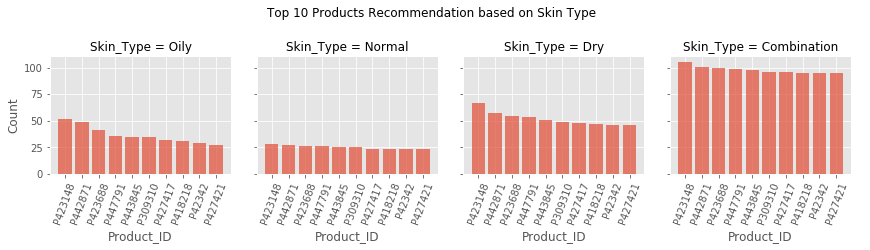

In [367]:
g = sns.FacetGrid(most_popular_comb, col = "Skin_Type")
g.map(plt.bar, "Product_ID", "Count", alpha=.7)
g.add_legend()
g.set_xticklabels(rotation=70)
plt.subplots_adjust(top=0.75)
g.fig.suptitle('Top 10 Products Recommendation based on Skin Type');

**Analysis:**

The above graph gives us the most popular products (arranged in descending order) sold by the business based on the Skin Type.


# Part II - Model-based collaborative filtering system

**Recommend products to users based on purchase history and similarity of ratings provided by other users who bought items to that of a particular customer.**

A model based collaborative filtering technique is chosen here as it helps in making predicting products for a particular user by identifying patterns based on preferences from multiple user data.

**Utility Matrix based on products sold and user reviews**

Utility Matrix

An utlity matrix is consists of all possible user-product preferences (ratings) details represented as a matrix. The utility matrix is sparce as none of the users would buy all the items in the list, hence, most of the values are unknown.

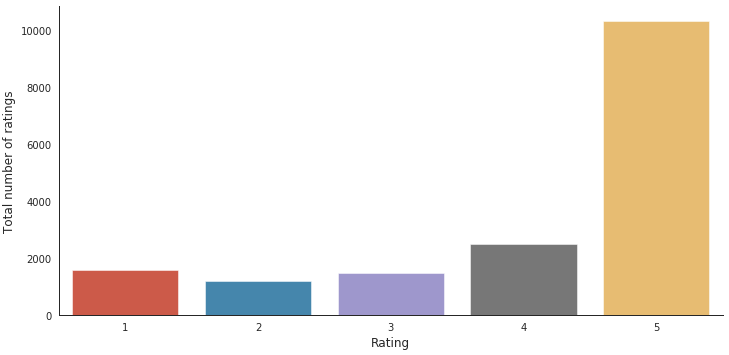

In [368]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.factorplot("Rating", data=df_ratings, aspect=2.0, kind='count')
    g.set_ylabels("Total number of ratings")

We can see that more number of users have given the rating of 5.

In [10]:
ratings_utility_matrix = df_ratings.pivot_table(values='Rating', index=['Skin_Type','Reviewer_Username'], columns='Product_ID', fill_value=0)#.reset_index()
ratings_utility_matrix.head(10)

Product_ID                     P122900  P126301  P199612  P222818  P248404  \
Skin_Type   Reviewer_Username                                                
Combination 007007007nina            0        0        0        0        0   
            0305lovelyone            0        0        0        0        0   
            032802                   0        0        0        0        0   
            0628                     0        0        0        0        0   
            0Loren0                  0        0        0        0        0   
            0hAMANDA                 0        0        0        0        0   
            1000attempts             0        0        0        0        0   
            100natalia               0        0        0        0        0   
            103368                   0        0        0        0        0   
            110011                   0        0        0        0        0   

Product_ID                     P248407  P254604  P266800  P271704  P278317  \
Skin_Type   Reviewer_Username                                                
Combination 007007007nina            0        0        0        0        0   
            0305lovelyone            0        0        0        0        0   
            032802                   0        0        0        0        0   
            0628                     0        0        0        0        0   
            0Loren0                  0        0        0        0        0   
            0hAMANDA                 0        0        0        0        0   
            1000attempts             0        0        0        0        0   
            100natalia               0        0        0        0        0   
            103368                   0        0        0        0        0   
            110011                   0        0        0        0        0   

Product_ID                     ...  P453229  P453928  P453930  P454380  \
Skin_Type   Reviewer_Username  ...                                       
Combination 007007007nina      ...        0        0        0        0   
            0305lovelyone      ...        0        0        0        0   
            032802             ...        0        0        0        0   
            0628               ...        0        0        0        0   
            0Loren0            ...        0        4        0        0   
            0hAMANDA           ...        0        0        0        0   
            1000attempts       ...        0        0        0        0   
            100natalia         ...        5        0        0        0   
            103368             ...        0        0        0        0   
            110011             ...        0        0        0        0   

Product_ID                     P454383  P454395  P45503  P455338  P6563  P7880  
Skin_Type   Reviewer_Username                                                   
Combination 007007007nina            0        0       0        0      0      0  
            0305lovelyone            0        0       0        0      0      0  
            032802                   0        0       0        0      0      0  
            0628                     0        0       0        0      0      0  
            0Loren0                  0        0       0        0      0      0  
            0hAMANDA                 0        0       0        0      0      0  
            1000attempts             0        0       0        5      0      0  
            100natalia               0        0       0        0      0      0  
            103368                   0        0       0        0      0      0  
            110011                   0        0       0        0      0      0  

[10 rows x 119 columns]

In [107]:
ratings_utility_matrix.shape

(14778, 119)

In [17]:
# Creating a copy of the ratings_utility_matrix just to get the index of the user
pivot_df = copy.deepcopy(ratings_utility_matrix).reset_index()
pivot_df.head(10)

Product_ID,Skin_Type,Reviewer_Username,P122900,P126301,P199612,P222818,P248404,P248407,P254604,P266800,...,P453229,P453928,P453930,P454380,P454383,P454395,P45503,P455338,P6563,P7880
0,Combination,007007007nina,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Combination,0305lovelyone,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Combination,032802,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Combination,0628,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Combination,0Loren0,0,0,0,0,0,0,0,0,...,0,4,0,0,0,0,0,0,0,0
5,Combination,0hAMANDA,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Combination,1000attempts,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5,0,0
7,Combination,100natalia,0,0,0,0,0,0,0,0,...,5,0,0,0,0,0,0,0,0,0
8,Combination,103368,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Combination,110011,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Singular Value Decomposition

In [108]:
U, sigma, Vt = svds(ratings_utility_matrix, k = 10)

In [109]:
print('Left singular matrix: \n',U)

Left singular matrix: 
 [[-0.01107772 -0.01880933 -0.02703553 ... -0.00463603 -0.01760172
  -0.01498808]
 [ 0.00417495 -0.00982455 -0.0093604  ...  0.00028914  0.00390894
  -0.00898574]
 [ 0.00071501 -0.00049266 -0.00193467 ...  0.00019896  0.00307133
  -0.00472565]
 ...
 [-0.00307002  0.00445311 -0.00315621 ... -0.00567344 -0.02016377
  -0.01780988]
 [-0.00351664 -0.00739251 -0.0042592  ...  0.00446703  0.00479111
  -0.01098325]
 [-0.00381699  0.0017502  -0.00213938 ...  0.00219781  0.00277658
  -0.00439675]]


In [110]:
# Construct diagonal array in SVD
sigma = np.diag(sigma)
print('Diagonal matrix: \n',sigma)

Diagonal matrix: 
 [[56.70588247  0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.         56.75981923  0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.         56.84754234  0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.         57.04209263  0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         57.09152115  0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         57.21319588
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  58.09487282  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.         58.57219954  0.          0.        ]
 [ 0.          0.          0.        

In [111]:
print('Right singular matrix: \n',Vt)

Right singular matrix: 
 [[-3.20736207e-02 -3.98828121e-02  2.10892939e-02 ...  1.45720321e-02
   1.46980204e-03 -2.10744437e-01]
 [-5.89523266e-03 -8.39195544e-02 -2.22357185e-02 ...  3.95538348e-03
  -2.83014790e-03  6.77259521e-02]
 [-2.45182654e-02 -4.84250376e-02  1.71658914e-02 ...  9.90834343e-03
  -1.63461849e-04 -2.08392430e-01]
 ...
 [ 1.48715916e-02  5.23287712e-02  4.72940131e-03 ... -1.54030269e-02
  -1.09910317e-03  4.94217771e-02]
 [ 7.71384353e-03  5.62406867e-02  2.13254882e-02 ... -8.78920629e-03
   2.00318464e-03  8.32633616e-02]
 [-5.50052554e-02 -1.37030001e-01 -2.45537279e-02 ... -2.83267326e-02
  -3.85631452e-03 -1.33355931e-01]]


In [112]:
# Predicted ratings
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
# Convert predicted ratings to dataframe
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = ratings_utility_matrix.columns)
preds_df.head()

Product_ID,P122900,P126301,P199612,P222818,P248404,P248407,P254604,P266800,P271704,P278317,...,P453229,P453928,P453930,P454380,P454383,P454395,P45503,P455338,P6563,P7880
0,0.098639,0.229640,-0.029269,0.054110,0.234204,0.196619,-0.648393,0.011993,-0.260235,0.171831,...,-0.095360,-0.049983,-0.044715,0.088143,0.011956,-0.002283,-0.418033,0.005981,0.002515,0.234301
1,0.008227,0.035482,0.019650,0.022593,0.011026,0.074989,-0.336766,0.001808,-0.063925,0.057785,...,0.030676,-0.010461,0.027063,0.266178,0.090255,0.005592,-0.201480,0.003290,0.003676,0.018260
2,0.015265,0.034015,0.008853,0.006413,0.010750,0.018786,-0.011456,0.003510,0.020097,0.028510,...,0.047784,0.011597,0.012191,0.070558,0.033990,0.002468,-0.018170,0.005480,0.001733,0.089305
3,0.000292,-0.000470,-0.000277,-0.000106,0.000458,-0.001018,0.002803,0.000379,-0.001440,0.001923,...,-0.000081,-0.000093,-0.000090,0.000665,0.000777,0.000038,-0.001255,0.001175,0.000020,-0.002519
4,0.012278,0.040104,0.006233,0.000397,0.051838,0.023811,0.018129,0.004451,0.059481,0.028179,...,0.012596,0.014398,0.001237,0.009976,0.002325,0.000333,0.086615,0.004089,0.000776,0.025374


In [123]:
def recommend(user, skin_type):
    user_idx = pivot_df.loc[pivot_df["Reviewer_Username"] == user].index.tolist()[0]
    # Get and sort the user's ratings
    sorted_user_ratings = ratings_utility_matrix.loc[(skin_type, user)]#.sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended_Items'
    temp.columns = ['user_ratings', 'user_predictions']
    # Filtering product with user_rating = 0 meaning recommending only products which has not been rated by this user
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print("\nUser: {}".format(user))
    print("\nSkin Type: {}".format(skin_type))
    print('\nBelow are the top 5 recommended products.\n')
    print(temp.head())

In [125]:
# Lets make first recommendation
recommend("0305lovelyone", "Combination")


User: 0305lovelyone

Skin Type: Combination

Below are the top 5 recommended products.

                   user_ratings  user_predictions
Recommended_Items                                
P411387                     0.0          0.501507
P432829                     0.0          0.435248
P442563                     0.0          0.415513
P430146                     0.0          0.405557
P446930                     0.0          0.380155


In [122]:
recommend("farce", "Dry")


User:farce

Skin Type:Dry

Below are the top 5 recommended products
                   user_ratings  user_predictions
Recommended_Items                                
P430146                     0.0          0.267866
P254604                     0.0          0.182314
P374211                     0.0          0.177678
P432829                     0.0          0.132765
P271704                     0.0          0.113379


In [116]:
# product_names = list(ratings_utility_matrix.index)
# product_names[10000]

## Evaluation of Collaborative filtering recommendation model

In [126]:
# Actual ratings given by the users
ratings_utility_matrix.head()

Product_ID                     P122900  P126301  P199612  P222818  P248404  \
Skin_Type   Reviewer_Username                                                
Combination 007007007nina            0        0        0        0        0   
            0305lovelyone            0        0        0        0        0   
            032802                   0        0        0        0        0   
            0628                     0        0        0        0        0   
            0Loren0                  0        0        0        0        0   

Product_ID                     P248407  P254604  P266800  P271704  P278317  \
Skin_Type   Reviewer_Username                                                
Combination 007007007nina            0        0        0        0        0   
            0305lovelyone            0        0        0        0        0   
            032802                   0        0        0        0        0   
            0628                     0        0        0        0        0   
            0Loren0                  0        0        0        0        0   

Product_ID                     ...  P453229  P453928  P453930  P454380  \
Skin_Type   Reviewer_Username  ...                                       
Combination 007007007nina      ...        0        0        0        0   
            0305lovelyone      ...        0        0        0        0   
            032802             ...        0        0        0        0   
            0628               ...        0        0        0        0   
            0Loren0            ...        0        4        0        0   

Product_ID                     P454383  P454395  P45503  P455338  P6563  P7880  
Skin_Type   Reviewer_Username                                                   
Combination 007007007nina            0        0       0        0      0      0  
            0305lovelyone            0        0       0        0      0      0  
            032802                   0        0       0        0      0      0  
            0628                     0        0       0        0      0      0  
            0Loren0                  0        0       0        0      0      0  

[5 rows x 119 columns]

In [128]:
# Average ACTUAL rating for each product
ratings_utility_matrix.mean().head()

Product_ID
P122900    0.040601
P126301    0.042969
P199612    0.043511
P222818    0.038639
P248404    0.043037
dtype: float64

In [129]:
# Predicted ratings 
preds_df.head()

Product_ID,P122900,P126301,P199612,P222818,P248404,P248407,P254604,P266800,P271704,P278317,...,P453229,P453928,P453930,P454380,P454383,P454395,P45503,P455338,P6563,P7880
0,0.098639,0.229640,-0.029269,0.054110,0.234204,0.196619,-0.648393,0.011993,-0.260235,0.171831,...,-0.095360,-0.049983,-0.044715,0.088143,0.011956,-0.002283,-0.418033,0.005981,0.002515,0.234301
1,0.008227,0.035482,0.019650,0.022593,0.011026,0.074989,-0.336766,0.001808,-0.063925,0.057785,...,0.030676,-0.010461,0.027063,0.266178,0.090255,0.005592,-0.201480,0.003290,0.003676,0.018260
2,0.015265,0.034015,0.008853,0.006413,0.010750,0.018786,-0.011456,0.003510,0.020097,0.028510,...,0.047784,0.011597,0.012191,0.070558,0.033990,0.002468,-0.018170,0.005480,0.001733,0.089305
3,0.000292,-0.000470,-0.000277,-0.000106,0.000458,-0.001018,0.002803,0.000379,-0.001440,0.001923,...,-0.000081,-0.000093,-0.000090,0.000665,0.000777,0.000038,-0.001255,0.001175,0.000020,-0.002519
4,0.012278,0.040104,0.006233,0.000397,0.051838,0.023811,0.018129,0.004451,0.059481,0.028179,...,0.012596,0.014398,0.001237,0.009976,0.002325,0.000333,0.086615,0.004089,0.000776,0.025374


In [130]:
# Average PREDICTED rating for each product
preds_df.mean().head()

Product_ID
P122900    0.019190
P126301    0.051225
P199612    0.012988
P222818    0.010073
P248404    0.059723
dtype: float64

In [133]:
rmse_df = pd.concat([ratings_utility_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df.head()

(119, 2)


,Avg_actual_ratings,Avg_predicted_ratings
Product_ID,,
P122900,0.040601,0.019190
P126301,0.042969,0.051225
P199612,0.043511,0.012988
P222818,0.038639,0.010073
P248404,0.043037,0.059723


![](../images/rmse.png)

![](./images/rmse.png)

In [134]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.01784 



**Summarising insights.**

The Popularity-based recommender system is a non-personalised recommender system and these are based on frequecy counts, which may be not suitable to the user. This type of recommendations is quite useful for the new users.

Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.

## Fin.